In [19]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import librosa
    
def file_to_feature(file_path, feature_type='chroma', ds=True):
    y, sr = librosa.load(file_path)
    feature = []

    if feature_type=='chroma':
        feature = librosa.feature.chroma_cens(y=y, sr=sr)

    if feature_type=='mfcc':
        feature = librosa.feature.mfcc(y=y, sr=sr)

    if feature_type=='tempo':
        oenv = librosa.onset.onset_strength(y=y, sr=sr)
        feature = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)
        
    if ds:
        feature, sr = downsample(feature, sr)
        
    return feature, sr

def downsample(feature, sr, downsampling_rate=32):
    N = feature.shape[1]/downsampling_rate
    F = feature.shape[0]
    ds = np.ndarray((F,N))
    for i in np.arange(N):
        ds[:,i] = np.mean(feature[:,downsampling_rate*i:downsampling_rate*(i+1)],axis=1)
    return ds, sr/downsampling_rate

def create_ssm(feature, enhance=True, threshold=90):
    ssm = np.dot(feature.T,feature)
    if enhance:
        ssm = enhance_diagonal(ssm)
        for x in np.arange(ssm.shape[0]):
            ssm[x,x] = 1 # Convolution makes the borders lose their values, just replacing it
    if threshold>0:
        ssm = apply_threshold(ssm, threshold)
    return ssm
    
def enhance_diagonal(ssm, kernel_size=8):
    kernel=np.identity(kernel_size)/kernel_size
    image, kernel = np.asarray(ssm), np.asarray(kernel, float)
    if len(image.shape) == 1: image = image[np.newaxis,:]
    if len(image.shape) == 1: kernel = kernel[np.newaxis,:]

    if image.size < kernel.size:
        image, kernel = kernel, image

    g = np.zeros(np.array(image.shape) + np.array(kernel.shape) - 1)
    if kernel.ndim == 2:
        H, W = image.shape
        for (r, c) in np.transpose(np.nonzero(kernel)):
            g[r:r+H, c:c+W] += image * kernel[r,c]

    if kernel.ndim == 3:
        D, H, W = image.shape
        for (D, H, W) in np.transpose(np.nonzero(kernel)):
            g[d:d+D, r:r+H, c:c+W] += image * kernel[d,r,c]

    additional_size = kernel.shape[0]//2, kernel.shape[1]//2
    image_size = g.shape
    return g[additional_size[0]:image_size[0]-additional_size[0],
             additional_size[1]:image_size[1]-additional_size[1]]

def apply_threshold(ssm, percentile=90):
    threshold = np.percentile(ssm, percentile)
    negative = (ssm<threshold)*2
    positive = ssm*(ssm>threshold)-(ssm>threshold)*threshold
    positive = positive/positive.max()
    return positive-negative
    
    
#############
#
# Fitness Calculation
#
############
def segmentScore(segment,ssm):
    l = segment[1]-segment[0]
    S = ssm[:,segment[0]:segment[1]]
    D = np.zeros((ssm.shape[0],l))
    D[0,0] = S[0,0]
    for x in range(1,l):
            D[0,x] = -np.inf
    for y in range(1,ssm.shape[0]):
        D[y,0] = max(D[y-1,-1],S[y,0]+D[y-1,0]-S[y-1,0])
        for x in range(1,l):
            D[y,x] = D[y-1,x-1]+S[y,x]
    E = np.zeros(ssm.shape)
    path_family = []
    x = l-1
    y = np.where(np.max(D[:,-1])==D[:,-1])[0][0]
    score = D[y,x]
    coverage = 0
    over_segment = 1
    while y!=0 or x!=0:
        if over_segment:
            coverage = coverage + 1
            E[y,segment[0]+x] = 1
            path_family.append((y,segment[0]+x))
        if x != 0:
            x -= 1
        else:
            over_segment = 0
            if D[y-1,0]<D[y-1,-1]:
                x = l-1
                over_segment = 1
        y -= 1
    return score, coverage, path_family, E

def fitnessMatrix(ssm):
    min_seg = 0
    max_seg = ssm.shape[0]
    min_size = 9
    max_size = ssm.shape[1]/4
    fitness_matrix = np.zeros((ssm.shape[0]/2,ssm.shape[1]))
    for i in np.arange(min_seg,max_seg):
        for j in np.arange(i+min_size,min(i+max_size,max_seg)):
            segment = (i,j)
            fitness_matrix[j-i,i] = fitness(segment, ssm)
    return fitness_matrix
    
def fitness(segment, ssm):
    score = 0
    coverage = 0
    segment_length = (segment[1] - segment[0])
    score, coverage, p_star, E = segmentScore(segment,ssm)
    normalized_score = (score - segment_length) / (len(p_star))
    normalized_coverage = (coverage - segment_length + 0.0) / ssm.shape[0]
    if normalized_score==0 or normalized_coverage==0:
        return 0
    return 2*normalized_score*normalized_coverage/(normalized_score+normalized_coverage)


#############
#
# Helpers for displaying matrices
#
############
def display_ssm(ssm, sr):
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(ssm, x_axis='time', y_axis='time', sr=sr, n_xticks=12)
    plt.title('ssm')
    plt.set_cmap('hot_r')
    plt.colorbar()
    plt.show()
    
def display_feature(feature, sr, feature_type='chroma'):
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(feature, sr=sr)
    if feature_type=='chroma':
        librosa.display.specshow(feature, x_axis='time',y_axis='chroma', sr=sr, n_xticks=12)
    if feature_type=='mfcc':
        librosa.display.specshow(feature, x_axis='time',y_axis='mel', sr=sr, n_xticks=12)
    if feature_type=='tempo':
        librosa.display.specshow(feature, x_axis='time',y_axis='tempo', sr=sr, n_xticks=12)
    plt.title(feature_type)
    plt.colorbar()
    plt.show()

def display_max_family(ssm, fm, sr):
    max_pos = np.where(fm==fm.max())
    max_segment = (x[1][0],x[1][0]+x[0][0])
    a,b,c,E = segmentScore(max_segment,ssm)
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(ssm+(E*2), x_axis='time', y_axis='time', sr=sr, n_xticks=12)
    plt.title('path family')
    plt.colorbar()
    plt.set_cmap('hot_r')
    plt.show()
    
def display_fitness(fitness_matrix, sr):
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(fitness_matrix, x_axis='time', y_axis='frames', sr=sr, n_xticks=12)
    plt.title('fitness matrix')
    plt.colorbar()
    plt.set_cmap('hot_r')
    plt.show()

feature, sr = file_to_feature('sun.wma')
ssm = create_ssm(feature)
#display_ssm(ssm, sr)
#display_feature(feature, sr)
fm = fitnessMatrix(ssm)
#display_fitness(fm,sr)
#display_max_family(ssm, fm, sr)

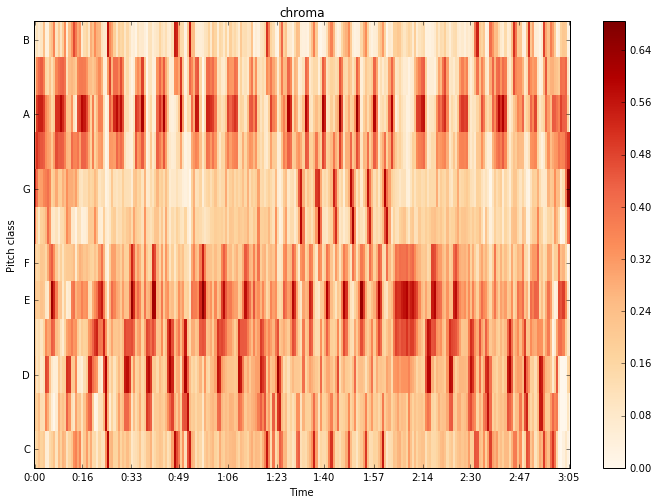

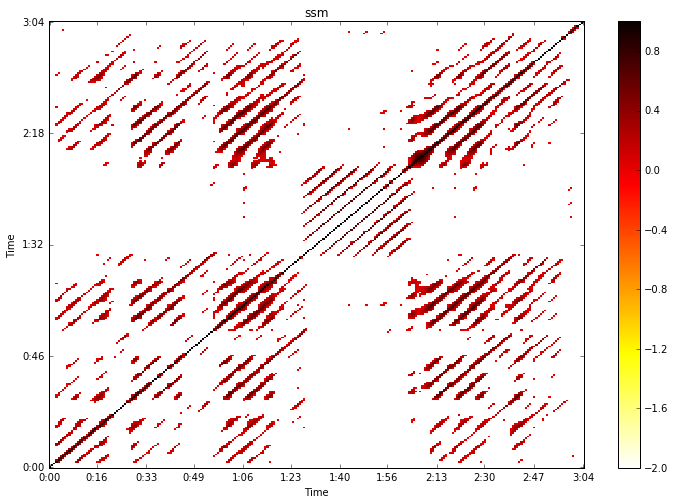

In [23]:
display_feature(feature, sr)
display_ssm(ssm, sr)

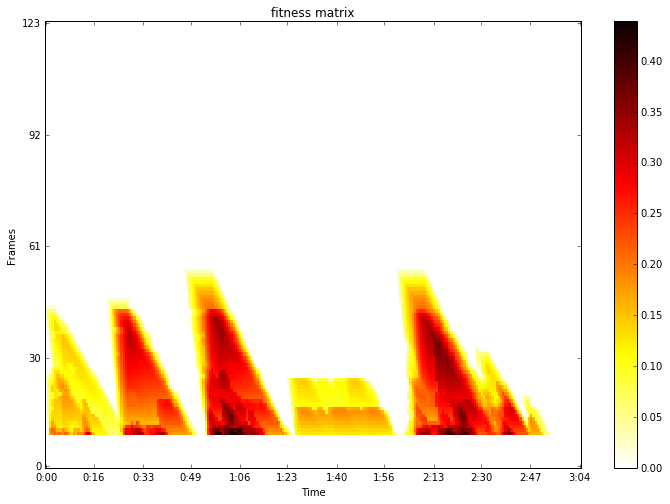

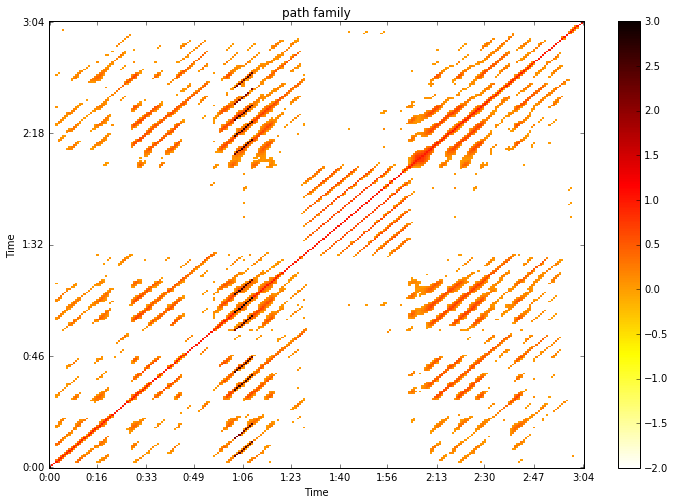

In [22]:
display_fitness(fm,sr)
display_max_family(ssm, fm, sr)

In [18]:
def pathFamilyScore(s,T,ssm):
    familyScore = 0
    pathFamily = []
    for t in T:
        score, path = pathScore(s,t,ssm)
        familyScore = familyScore + score
        pathFamily.append(path)
    return familyScore, pathFamily

def pathScore(s,t,ssm):
    score = ssm[t]
    pathcells = [t]
    while t[0]>s:
        t = (t[0]-1,t[1]-1)
        score = score + ssm[t]
        if t[1]<0:
            score = -np.inf
            break
        pathcells.append(t)
    return score, pathcells